# 使用决策树预测隐形眼镜类型

1. 收集数据：提供的文本文件
2. 准备数据：解析tab键分割的数据行
3. 分析数据：快速检查数据，确保正确地解析数据内容，使用createPlot()函数绘制最终的树形图
4. 训练算法：使用createTree()函数
5. 测试算法：编写测试函数验证决策树可以正确分类给定的数据实例
6. 使用算法：存储树的数据结构，以便下次使用时无需重新构造树

In [1]:
from math import log
import matplotlib.pyplot as plt

## 收集数据

In [2]:
fr = open('lenses.txt')

## 准备数据

### 隐形眼镜数据

In [3]:
lenses = [inst.strip().split('\t') for inst in fr.readlines()]

### 隐形眼镜分类特征

In [4]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

## 分析数据与训练数据

### 计算给定数据集的香农熵

In [5]:
def calcShannonEnt(dataSet):
    # 得到整个数据集的总数
    numEntries = len(dataSet)
    # 为所有可能分类创建字典
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel, 0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        # 分类的概率
        prob = float(labelCounts[key]) / numEntries
        # 以2为底求对数
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

### 按照给定特征划分数据集

In [6]:
# dataSet为待划分的数据集，axis为划分数据集的特征值所在的位置， value需要返回的特征的值
# list.extend() 函数用于在列表末尾一次性追加另一个序列中的多个值（用新列表扩展原来的列表）。
# list.append() 方法用于在列表末尾添加新的对象。
def splitDataSet(dataSet, axis, value):
    # 创建新的list对象
    retDataSet = []
    for featVec in dataSet:
        # 发现符合要求的值，则将其添加到新创建的列表中。
        if featVec[axis] == value:
            # 将符合特征的数据抽取出来
            # 将其他的列数据抽取出来
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis + 1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

### 选择最好的数据集划分方式

In [7]:
# 选取特征，划分数据集，计算得出最好的划分数据集的特征
def chooseBestFeatureToSplit(dataSet):
    # 特征值的个数，在本例中为2个
    numFeatures = len(dataSet[0]) - 1
    # 得到信息熵
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        # 创建唯一的分类标签列表
        # 重新创建特征值列表
        featList = [example[i] for example in dataSet]
        # 进行去重处理
        uniqueVals = set(featList)
        newEntropy = 0.0
        # 计算每种划分方式的信息熵
        for value in uniqueVals:
            # 按照给定的特征划分数据集
            subDataSet = splitDataSet(dataSet, i, value)
            # 计算概率
            prob = len(subDataSet) / float(len(dataSet))
            # 对所有唯一特征值得到的熵求和
            newEntropy += prob * calcShannonEnt(subDataSet)
        # 取熵最大的特征值
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    # 返回最好特征值划分的索引值
    return bestFeature

### 采用多数表决的方法决定叶子节点的分类

In [8]:
# classList为分类名称的列表
def majorityCnt(classList):
    # 创建键值为classList中唯一值的数据字典，字典对象存储了classList中每个类标签出现的频率
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items(), 
                             key=operator.itemgetter(1),
                             reverse=True)
    return sortedClassCount[0][0]

### 创建树

In [9]:
# dataSet为数据集，labels为标签列表
def createTree(dataSet, labels):
    # 得到类标签
    classList = [example[-1] for example in  dataSet]
    # 类别完全相同则停止继续划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 遍历完所有特征则返回出现次数最多的
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    # 选择最好的数据集划分的特征值
    bestFeat = chooseBestFeatureToSplit(dataSet)
    # 获得特征值的标签
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    # 删除处理过的标签
    del labels[bestFeat]
    # 取出同一个特征值的数据
    featValues = [example[bestFeat] for example in dataSet]
    # 过滤重复数据
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

### 训练数据：创建隐形眼镜分类树

In [10]:
lensesTree = createTree(lenses, lensesLabels)

In [11]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

### 使用文本注解绘制树节点

In [12]:
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

# 解决matplotlib中文编码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', 
                           xytext=centerPt, textcoords='axes fraction',
                           va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

### 遍历整棵树，累计叶子节点的个数

In [13]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 测试节点的数据类型是否为字典
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

### 计算树的深度（层数）

In [14]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 树深度加一
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

### 绘制树

In [15]:
def plotMidText(cntrPt, parentPt, txtString):
    # 在父子节点间填充文本信息
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    # 计算宽与高
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    # 标记子节点属性值
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    # 减少y偏移
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    # 树的宽度
    plotTree.totalW = float(getNumLeafs(inTree))
    # 树的深度
    plotTree.totalD = float(getTreeDepth(inTree))
    # 初始化绘制节点位置
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

### 展示隐形眼镜分类的决策树

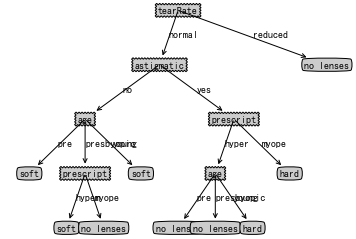

In [16]:
createPlot(lensesTree)

## 测试数据

In [17]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    # 将标签字符串转换为索引
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                # 到达叶子节点，返回当前节点的分类标签
                classLabel = secondDict[key]
    return classLabel

In [18]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

In [19]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

In [20]:
classify(lensesTree, lensesLabels, ['young', 'hyper', 'yes', 'normal'])

'hard'

根据给出的数据，可以得到正确的预测结果，年龄为young，症状为hyper，是否散光为yes，流泪频率为normal，最后得到的预测结果为硬材质(hard)，需要使用硬材质的隐形眼镜

## 使用算法：决策树的存储

In [21]:
def storeTree(inputTree, fileName):
    import pickle
    fw = open(fileName, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(fileName):
    import pickle
    fr = open(fileName, 'rb')
    return pickle.load(fr)

In [22]:
storeTree(lensesTree, 'lensesClassifierStorage.txt')

In [23]:
grabTree('lensesClassifierStorage.txt')

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}